In [57]:
import numpy as np
import pandas as pd
import cv2  # OpenCV
import rasterio
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import ee  # Earth Engine API
import geemap
import os
import leaflet
import ipywidgets as widgets

import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler

In [61]:
#os.remove(os.path.expanduser('~/.config/earthengine/credentials'))
ee.Authenticate()
ee.Initialize(project='nikolavukasinovic')

# Definišemo područje interesa (AOI) - Stavio da bude moje selo - to ce da bude test
aoi = ee.Geometry.Polygon([
    [
        [20.611538, 43.045487],  # Ugao 1 (Jugo Zapadna granica)
        [20.619155, 43.045487],  # Ugao 2 (Jugo Istočna granica)
        [20.619155, 43.051737],  # Ugao 3 (Severo Istočna granica)
        [20.611538, 43.051737]   # Ugao 4 (Severo Zapadna granica)
    ]
])

# Definišemo drugo područje interesa (AOI) - Stavio da bude pokrcena suma u Amazonu - train
aoi2 = ee.Geometry.Polygon([
    [
        [-60.230, -3.540],  # Ugao 1 (Jugo Zapadna granica)
        [-60.220, -3.540],  # Ugao 2 (Jugo Istočna granica)
        [-60.220, -3.530],  # Ugao 3 (Severo Istočna granica)
        [-60.230, -3.530]   # Ugao 4 (Severo Zapadna granica)
    ]
])

# Definišemo drugo područje interesa (AOI) - Stavio da bude gusta vegetacija iz Severne amerike - train
aoi3 = ee.Geometry.Polygon([
    [
        [-83.540, 35.625],  # Ugao 1 (Jugo Zapadna granica)
        [-83.530, 35.625],  # Ugao 2 (Jugo Istočna granica)
        [-83.530, 35.635],  # Ugao 3 (Severo Istočna granica)
        [-83.540, 35.635]   # Ugao 4 (Severo Zapadna granica)
    ]
])

def calculate_ndvi_evi(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    evi = image.expression(
        '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))',
        {
            'NIR': image.select('B8'),
            'RED': image.select('B4'),
            'BLUE': image.select('B2')
        }).rename('EVI')
    return image.addBands([ndvi, evi])


datasets = [
    ee.ImageCollection('COPERNICUS/S2_HARMONIZED').filterDate('2015-01-01', '2022-12-31').filterBounds(aoi2).map(calculate_ndvi_evi),
    ee.ImageCollection('COPERNICUS/S2_HARMONIZED').filterDate('2015-01-01', '2022-12-31').filterBounds(aoi3).map(calculate_ndvi_evi),
]

combined_dataset = ee.ImageCollection(datasets[0])

for dataset in datasets[1:]:
    combined_dataset = combined_dataset.merge(dataset)
images = combined_dataset.median()


dataset_test = ee.ImageCollection('COPERNICUS/S2_HARMONIZED').filterDate('2015-01-01', '2022-12-31').filterBounds(aoi).map(calculate_ndvi_evi)
image = ee.Image(dataset_test.first())

vis_params = {
    'bands': ['B4', 'B3', 'B2'],  # RGB bands
    'min': 0,
    'max': 3000,
    'gamma': 1.4
}

# Pravimo mapu za vizuelizaciju
Map = geemap.Map()
Map.centerObject(aoi, 13)
Map.addLayer(image, vis_params, 'RGB Image')
Map.addLayer(aoi, {}, 'AOI')
Map.addLayerControl()
Map

Map(center=[43.048612010054555, 20.615346499989577], controls=(WidgetControl(options=['position', 'transparent…

In [62]:
def calculate_ndvi(image):
    # Racunamo NDVI: (NIR - Red) / (NIR + Red)
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return image.addBands(ndvi)

# Uzimamo prosecnu sliku za period 2015-2022 za NDVI i EVI
median_ndvi = combined_dataset.select('NDVI').median() 
median_evi = combined_dataset.select('EVI').median() 

# Selo
median_ndvi_test = dataset_test.select('NDVI').median().clip(aoi)
median_evi_test = dataset_test.select('EVI').median().clip(aoi)

# Amazon
median_ndvi2 = datasets[0].select('NDVI').median() 
median_evi2 = datasets[0].select('EVI').median() 

# Amerika
median_ndvi3 = datasets[1].select('NDVI').median() 
median_evi3 = datasets[1].select('EVI').median() 

# Postavljamo parametre za NDVI (Normalized Difference Vegetation Index)
ndvi_params = {
    'min': -1,
    'max': 1,
    'palette': ['blue', 'white', 'green']
}

# Visualize NDVI
Map = geemap.Map()
Map.centerObject(aoi, 13)
Map.addLayer(median_ndvi_test, ndvi_params, 'Median NDVI')
Map.addLayer(aoi, {}, 'AOI')
Map.addLayerControl()
Map

Map(center=[43.048612010054555, 20.615346499989577], controls=(WidgetControl(options=['position', 'transparent…

In [23]:
images_folder = os.path.join(os.getcwd(), 'images')
export_path = os.path.join(images_folder, 'median_ndvi_test.tif')
export_path1 = os.path.join(images_folder, 'median_evi_test.tif')
export_path2 = os.path.join(images_folder, 'median_ndvi_train1.tif')
export_path3 = os.path.join(images_folder, 'median_evi_train1.tif')
export_path4 = os.path.join(images_folder, 'median_ndvi_train2.tif')
export_path5 = os.path.join(images_folder, 'median_evi_train2.tif')

# Exportujemo test slike na lokal
geemap.ee_export_image(
    median_ndvi_test,
    filename=export_path,
    scale=5,
    region=aoi.getInfo()['coordinates']
)

geemap.ee_export_image(
    median_evi_test,
    filename=export_path1,
    scale=5,
    region=aoi.getInfo()['coordinates']
)

# Exportujemo train slike na lokal
geemap.ee_export_image(
    median_ndvi2,
    filename=export_path2,
    scale=10,
    region=aoi2.getInfo()['coordinates']
)

geemap.ee_export_image(
    median_evi2,
    filename=export_path3,
    scale=10,
    region=aoi2.getInfo()['coordinates']
)

geemap.ee_export_image(
    median_ndvi3,
    filename=export_path4,
    scale=10,
    region=aoi3.getInfo()['coordinates']
)

geemap.ee_export_image(
    median_evi3,
    filename=export_path5,
    scale=10,
    region=aoi3.getInfo()['coordinates']
)

Generating URL ...
Please wait ...
Data downloaded to k:\DetekcijaSuma\images\median_ndvi_test.tif
Generating URL ...
Please wait ...
Data downloaded to k:\DetekcijaSuma\images\median_evi_test.tif
Generating URL ...
Please wait ...
Data downloaded to k:\DetekcijaSuma\images\median_ndvi_train1.tif
Generating URL ...
Please wait ...
Data downloaded to k:\DetekcijaSuma\images\median_evi_train1.tif
Generating URL ...
Please wait ...
Data downloaded to k:\DetekcijaSuma\images\median_ndvi_train2.tif
Generating URL ...
Please wait ...
Data downloaded to k:\DetekcijaSuma\images\median_evi_train2.tif


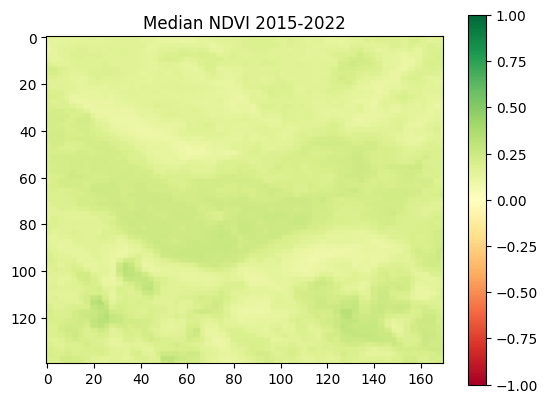

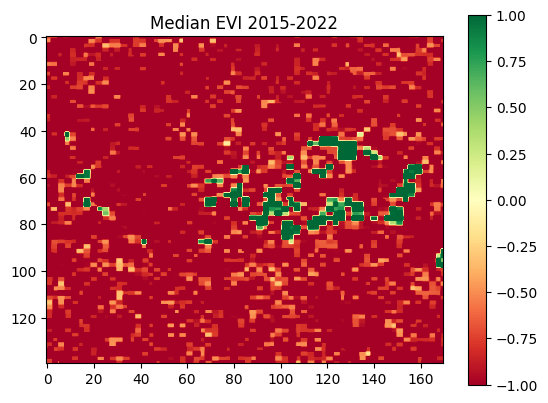

In [24]:
# Ucitavamo exportovanu NDVI test sliku
with rasterio.open(export_path) as src:
    ndvi_data_test = src.read(1)  # Citamo prvi band
    profile = src.profile

# Ucitavamo exportovanu EVI test sliku
with rasterio.open(export_path1) as src:
    evi_data_test = src.read(1)  # Citamo prvi band
    profile = src.profile

# Ucitavamo exportovanu NDVI train1 sliku
with rasterio.open(export_path2) as src:
    ndvi_data1 = src.read(1)  # Citamo prvi band
    profile = src.profile

# Ucitavamo exportovanu EVI train1 sliku
with rasterio.open(export_path3) as src:
    evi_data1 = src.read(1)  # Citamo prvi band
    profile = src.profile

# Ucitavamo exportovanu NDVI train2 sliku
with rasterio.open(export_path4) as src:
    ndvi_data2 = src.read(1)  # Citamo prvi band
    profile = src.profile

# Ucitavamo exportovanu EVI train2 sliku
with rasterio.open(export_path5) as src:
    evi_data2 = src.read(1)  # Citamo prvi band
    profile = src.profile

# Prikaz test NDVI slike
plt.imshow(ndvi_data_test, cmap='RdYlGn', vmin=-1, vmax=1)
plt.colorbar()
plt.title('Median NDVI 2015-2022')
plt.show()

# Prikaz test EVI slike
plt.imshow(evi_data_test, cmap='RdYlGn', vmin=-1, vmax=1)
plt.colorbar()
plt.title('Median EVI 2015-2022')
plt.show()



In [70]:
dataset2023 = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
            .filterDate('2023-01-01', '2023-12-31') \
            .filterBounds(aoi)

dataset_2023_ndvi = dataset2023.map(calculate_ndvi)
median_ndvi_2023 = dataset_2023_ndvi.select('NDVI').median().clip(aoi)

dataset2015 = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
            .filterDate('2015-01-01', '2015-12-31') \
            .filterBounds(aoi)

dataset_2015_ndvi = dataset2015.map(calculate_ndvi)
median_ndvi_2015 = dataset_2015_ndvi.select('NDVI').median().clip(aoi)

# Razlika izmedju dva perioda
ndvi_difference = median_ndvi_2023.subtract(median_ndvi_2015)

diff_params = {
    'min': -0.5,
    'max': 0.5,
    'palette': ['red', 'white', 'green']
}

Map.addLayer(ndvi_difference, diff_params, 'NDVI Difference')
Map.addLayerControl()
Map


Map(bottom=6162047.0, center=[43.04751828702473, 20.616745948791507], controls=(WidgetControl(options=['positi…

In [71]:
assert ndvi_data1.shape == ndvi_data2.shape, "NDVI slike moraju da budu istih dimenzija"
assert evi_data1.shape == evi_data2.shape, "EVI slike moraju da budu istih dimenzija"

Confusion Matrix:
[[2744    0]
 [   0  449]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2744
           1       1.00      1.00      1.00       449

    accuracy                           1.00      3193
   macro avg       1.00      1.00      1.00      3193
weighted avg       1.00      1.00      1.00      3193



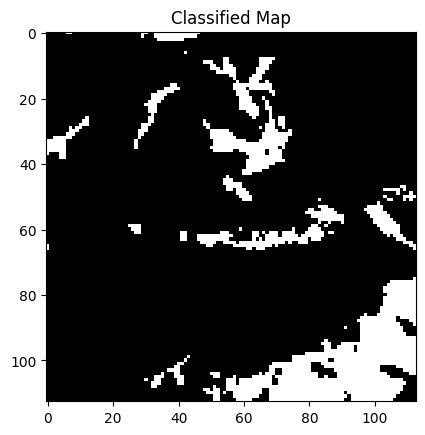

In [74]:
ndvi_data = np.median([ndvi_data1, ndvi_data2], axis=0)
evi_data = np.median([evi_data1, evi_data2], axis=0)

# Priprema feature-a za trening, kombinovanje NDVI i EVI u feature
X = np.vstack([
    ndvi_data.flatten(), 
    evi_data.flatten() 
]).T 

# Gde su ndvi i evi manji od 0.2 racunacemo da je pokrceno(deforestation) a ostali ce da upadnu u sume
labels = np.where((ndvi_data < 0.2) & (evi_data < 0.2), 1, 0)
y = labels.flatten()  # Labels (0 i dalje sume, 1 pokrceno)

scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)

# Deljenje podataka na train i test skupove u odnosu 75/25
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)

# Inicijalizacija RandomForestClassifier sa 100 jedinica
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Treniranje modela
rf_classifier.fit(X_train, y_train)

# Prediktovanje
y_pred = rf_classifier.predict(X_test)

# Evaluacija modela
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Vizualizacija klasifikovane mape
classified_map = rf_classifier.predict(X_scaled).reshape(ndvi_data.shape)
plt.imshow(classified_map, cmap='gray')
plt.title('Classified Map')
plt.show()


Confusion Matrix:
[[  876   102]
 [ 7187 15635]]

Classification Report:
              precision    recall  f1-score   support

           0       0.11      0.90      0.19       978
           1       0.99      0.69      0.81     22822

    accuracy                           0.69     23800
   macro avg       0.55      0.79      0.50     23800
weighted avg       0.96      0.69      0.79     23800



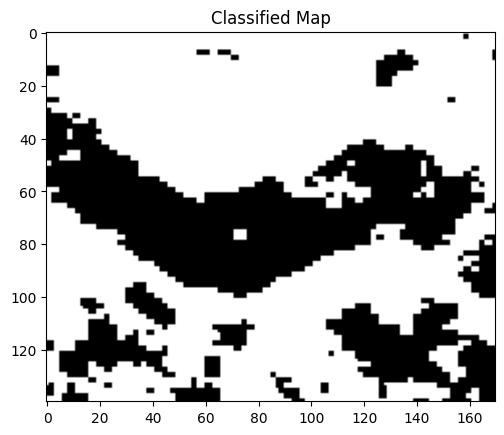

In [75]:
new_X = np.vstack([
    ndvi_data_test.flatten(), 
    evi_data_test.flatten()    
]).T

new_X_scaled = scaler.transform(new_X)

labels2 = np.where((ndvi_data_test < 0.3) & (evi_data_test < 0.3), 1, 0)
y_pred2 = rf_classifier.predict(new_X_scaled)
y_true2 = labels2.flatten()

# Evaluacija modela na novim nepoznatim do sad podacima
print("Confusion Matrix:")
print(confusion_matrix(y_true2, y_pred2))

print("\nClassification Report:")
print(classification_report(y_true2, y_pred2))

new_classified_map = rf_classifier.predict(new_X_scaled).reshape(ndvi_data_test.shape)
plt.imshow(new_classified_map, cmap='gray')
plt.title('Classified Map')
plt.show()

Confusion Matrix:
[[2744    0]
 [   0  449]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2744
           1       1.00      1.00      1.00       449

    accuracy                           1.00      3193
   macro avg       1.00      1.00      1.00      3193
weighted avg       1.00      1.00      1.00      3193



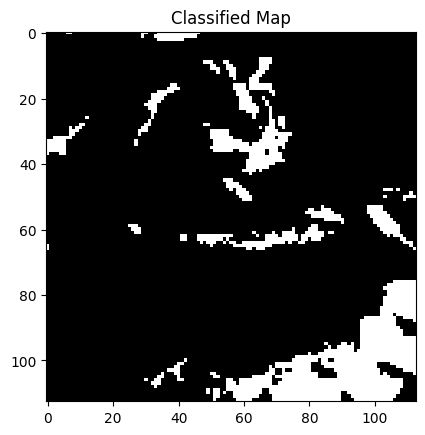

In [55]:
# Inicijalizacija logisticke regresije
logistic_classifier = LogisticRegression(max_iter=1000, random_state=42)

# Treniarnje modela
logistic_classifier.fit(X_train, y_train)

# Predikcija
y_pred3 = logistic_classifier.predict(X_test)

# Provera modela
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Vizuelizacija rezultata logisticke regresije
classified_map2 = logistic_classifier.predict(X_scaled).reshape(ndvi_data.shape)
plt.imshow(classified_map2, cmap='gray')
plt.title('Classified Map')
plt.show()


Confusion Matrix:
[[  810   168]
 [ 7547 15275]]

Classification Report:
              precision    recall  f1-score   support

           0       0.10      0.83      0.17       978
           1       0.99      0.67      0.80     22822

    accuracy                           0.68     23800
   macro avg       0.54      0.75      0.49     23800
weighted avg       0.95      0.68      0.77     23800



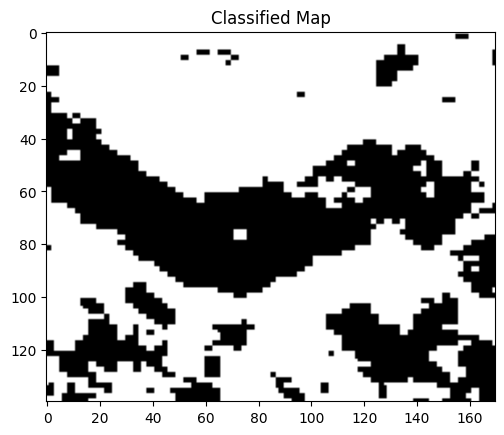

In [56]:
y_pred4 = logistic_classifier.predict(new_X_scaled)
y_true4 = labels2.flatten()

# Evaluacija modela logisticke regresije na novim, do sad nepoznatim, podacima
print("Confusion Matrix:")
print(confusion_matrix(y_true4, y_pred4))

print("\nClassification Report:")
print(classification_report(y_true4, y_pred4))

new_classified_map2 = logistic_classifier.predict(new_X_scaled).reshape(ndvi_data_test.shape)
plt.imshow(new_classified_map2, cmap='gray')
plt.title('Classified Map')
plt.show()

In [ ]:
def send_email(subject, body, to_email):
    from_email = 'mojemail@gmail.com'
    from_password = 'lozinka'
    
    msg = MIMEMultipart()
    msg['From'] = from_email
    msg['To'] = to_email
    msg['Subject'] = subject

    msg.attach(MIMEText(body, 'plain'))

    try:
        server = smtplib.SMTP('smtp.example.com', 587)
        server.starttls()
        server.login(from_email, from_password)
        text = msg.as_string()
        server.sendmail(from_email, to_email, text)
        server.quit()
        print("Email sent successfully")
    except Exception as e:
        print(f"Failed to send email: {e}")


In [ ]:
def check_deforestation(ndvi_data):
    if ndvi_data.min() < 0.3:
        return True
    return False

#izabrati samo sumsku oblast za proveru

def monitor_deforestation_and_notify():
    new_ndvi_data = load_ndvi_data() # 

    if check_deforestation(new_ndvi_data):
        send_email('Alarm: Detekcija bespravne sece sume', 'Bespravna seca je zabelezena u tvojoj oblasti.', 'nekome@gmail.com')

monitor_deforestation_and_notify()

In [16]:
# Oznacio oblast na mapi GFW-a
# Skinuti podatke za tree cover loss
# Skinuti podatke za tree cover by type
# Sacuvati podatke lokalno
# I posle 2 nedelje nemam opciju da skinem podatke?? a pise na GFW-u od 12-24h da se ceka za podatke 

# Ucitavanje podataka

import rasterio
import matplotlib.pyplot as plt

# Putanja do skinutih GeoTIFF fajlova
file_path_loss = os.path.join(os.getcwd(), 'treecover_loss')
file_path_type = os.path.join(os.getcwd(), 'treecover_type')

with rasterio.open(file_path_loss) as src:
    tree_cover_loss = src.read(1)  
    profile = src.profile

df = pd.DataFrame(tree_cover_loss, columns=['TreeCoverLoss'])

# Vizualizacija podataka
plt.imshow(tree_cover_loss , cmap='RdYlGn', vmin=0, vmax=1)  
plt.colorbar()
plt.title('Tree Cover Loss')
plt.show()

RasterioIOError: k:/DetekcijaSuma/treecover_loss: Permission denied

In [ ]:
#Preprocesing

import json
from rasterio.mask import mask

aoi_geojson = {
    "type": "Polygon",
    "coordinates": [
        [
            [20.611538, 43.045487],
            [20.619155, 43.045487],
            [20.619155, 43.051737],
            [20.611538, 43.051737],
            [20.611538, 43.045487]  # Jos jedna tacka za zatvaranje poligona, kao na Global Forest Watchu
        ]
    ]
}

with open('aoi.geojson', 'w') as f:
    json.dump(aoi_geojson, f)
    

with rasterio.open(file_path_loss) as src:
    out_image, out_transform = mask(src, [aoi_geojson], crop=True)
    out_meta = src.meta.copy()

# Promena metapodataka za klipovanu sliku
out_meta.update({
    "driver": "GTiff",
    "count": 1,
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform
})

# Cuvanje klipovane slike
clipped_file_path = os.path.join(os.getcwd(), 'clipped_tree_cover_loss.tiff')
with rasterio.open(clipped_file_path, "w", **out_meta) as dest:
    dest.write(out_image)

In [ ]:
import rasterio
import pandas as pd
import matplotlib.pyplot as plt

# Ucitavanje klipovane NDVI slike
with rasterio.open(clipped_file_path) as src:
    tree_cover_loss_data = src.read(1) 
    profile = src.profile

df = pd.DataFrame(tree_cover_loss_data)

df_flat = df.stack().reset_index()
df_flat.columns = ['row', 'col', 'TreeCoverLoss']

threshold = 10
df_flat['Label'] = np.where(df_flat['TreeCoverLoss'] > threshold, 1, 0)
